# Predictors.ai examples for Data Scientists

version 0.03
(this is a pre-alpha release and the current version of Predictors.ai does not support yet the functionalities presented in this document)

## Introduction

Predictors.ai allows you to share your predictors with the rest of the world.

To do so, you just have to:
- Add one function to your model, which will be used by Predictors.ai to interact with it.
- Create three files that describe your model. These files will be used by Predictors.ai to generate the user interface.

The three files used to describe your model are:

- model_definition.json: Contains information such as the name of the model, description, inputs and outputs and so on.
- scores.json: Contains the scores that measure the performance of the predictor.

Aside those JSON files, Predictors.ai needs two more files to run your predictor:

- predictor.py: Source code of the predictor.
- predictor.pk: Trained predictor serialized with pickle.

This guide contains three examples on how to get a model ready to be interpreted by Predictors.ai.

For more information about these files and its syntax please visit: http://predictors.ai/#/docs

## Working diagram

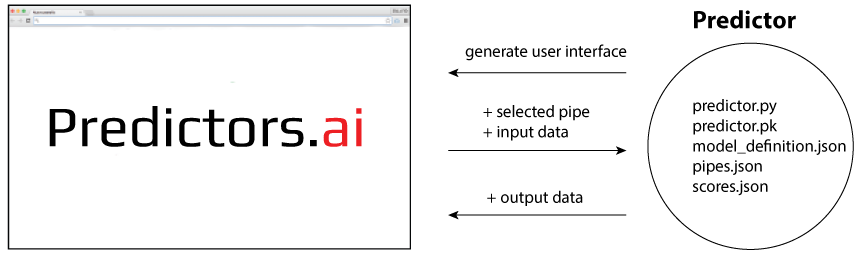

In [2]:
from IPython.display import Image
Image(filename='./working_diagram.png')

## Example 1: The Iris predictor

This example shows how to share the classic Iris classifier in Predictors.ai.

The next cell contains the source code of the predictor. It can be seen that it has the mandatory function "load_data_and_predict" and also contains the function "load_data_and_train", since we will allow the model to be re-trained by the admins. Also, we can observe how the class is named "DPModel", which is a mandatory requirement.

### Source code:

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import json
import os

class IrisModel:
    
    def predictors_ai_interface(self, **kwargs):
        
        """
        This is the method used by Predictors.ai to interact with the model.
        
        Inputs:
                
        - pipe_id (integer): id of the pipe that has to be used.
        
        - input_data (dictionary): dictionary that contains the input data. The keys of the dictionary 
        correspond to the names of the inputs specified in models_definition.json for the selected pipe.
        Each key has an associated value. For the input variables the associated value is the value
        of the variable, whereas for the input files the associated value is its filename. 
        
        - input_files_dir (string): Relative path of the directory where the input files are stored
        (the algorithm has to read the input files from there).

        - output_files_dir (string): Relative path of the directory where the output files must be stored
        (the algorithm must store the output files in there).
        
        Outputs:
        
        - output_data (dictionary): dictionary that contains the output data. The keys of the dictionary 
        correspond to the names of the outputs specified in models_definition.json for the selected pipe. 
        Each key has an associated value. For the output variables the associated value is the value
        of the variable, whereas for the output files the associated value is its filename.  

        """
        
        pipe_id = kwargs['pipe_id']
        input_data = kwargs['input_data']
        input_files_dir = kwargs['input_files_dir']
        output_files_dir = kwargs['output_files_dir']
        
        output_data = self.train_or_predict(pipe_id, input_data, input_files_dir, output_files_dir)
        
        return output_data
        
    
    def train_or_predict(self, pipe_id, input_data, input_files_dir, output_files_dir):
        
        """
        Handles user requests.
        
        """
        
        # pipes for prediction
        if pipe_id in [0,1]:

            # load data
            if pipe_id == 0:
                data = []
                for feature in self.feature_names:
                    data.append(input_data[feature])

            elif pipe_id == 1:
                data, data_args = self.load_input_files(input_data=input_data, input_files_dir=input_files_dir, training_data=False)
                data = data["features"]

            # make prediction
            prediction, out_args = self.predict(features=data)

            # decode prediction
            prediction = self.LabelEncoder.inverse_transform(prediction)

            # return answer
            if pipe_id == 0:
                output_data = {}
                output_data[self.target_name] = prediction[0]
                return output_data

            elif pipe_id == 1:
                # save output in csv file and return it
                filename = 'predictions.csv'
                filepath = os.path.join(output_files_dir, filename)
                df = pd.DataFrame(data=data, columns=self.feature_names)
                df[self.target_name] = prediction
                df.to_csv(filepath, index=False)
                output_data = {}
                output_data["file with predictions"] = filename
                return output_data
            else:
                return
        
        # training pipe
        elif pipe_id in [2]:

            # load data
            data, data_args = self.load_input_files(input_data=input_data, input_files_dir=input_files_dir, training_data=True)

            # find best hyperparameters and fit model
            predictor, out_args = self.find_best_parameters_and_get_fitted_model(data=data, set_predictor_after_training=True)
            # set fitted predictor as the default for the DPModel
            self.predictor = predictor

            # save the label encoder
            self.LabelEncoder = data_args['LabelEncoder']

            # get unbiased predictions on training data
            y_true, y_pred, unbiased_prediction_args = self.get_unbiased_predictions_on_training_data(data=data)

            output_data = {}

            # save model_configuration.json
            model_definition, out_args = self.get_model_definition(data_args=data_args)
            path = os.path.join(output_files_dir, "model_definition.json")
            self.save_json_file(dict_to_save=model_definition, path=path)
            output_data["model_definition"] = "model_definition.json"

            # save scores.json
            scores, out_args = self.get_scores(data=data, true_values=y_true, predicted_values=y_pred, data_args=data_args)
            path = os.path.join(output_files_dir, "scores.json")
            self.save_json_file(dict_to_save=scores, path=path)
            output_data["scores"] = "scores.json"

            return output_data
            
        else:
            return


    def load_input_files(self, **kwargs):
        
        """
        Loads both files containing training data and data for prediction. 
        
        Encodes the target labels to integers. 
        
        In case the it is training data, it will return in the output args the 
        LabelEncoder used to encode the target labels to integers. We return it 
        instead of directly storing it, because it will be saved in case the training
        ends without errors.
        
        Inputs:
        - files_paths (string): path the input files.
        - training_data (bool): specifies whether the files containing training
        data or data for making predictions.
        
        Outputs:
        - LabelEncoder (LabelEncoder) (optional): Encodes the labels of the target
        variables to integers.
        
        """
        
        input_data = kwargs['input_data']
        input_files_dir = kwargs['input_files_dir']

        input_file_path = input_files_dir + input_data['database']
        df = pd.read_csv(input_file_path)
        
        training_data = kwargs.pop('training_data', False)
        
        # if we are loading training data, we have to assign an integer to each possible
        # target label in the dataset. We do it by fitting a LabelEncoder,
        if training_data:

            le = LabelEncoder()
            col_name = df.columns[4]
            df[col_name] = le.fit_transform(df[col_name])

            data = {}
            data['features'] = df[df.columns[0:4]].values
            data['targets'] = df[df.columns[4]].values

            self.feature_names = list(df.columns[0:4])
            self.target_name = df.columns[4]    

            out_args = {}
            out_args['LabelEncoder'] = le
            
            return data, out_args

        # if the data is for making predictions
        else:
            data = {}
            # ensure that the columns are in the correct order
            data['features'] = df[self.feature_names].values
            
            out_args = {}
        
            return data, out_args
    
    
    def find_best_parameters_and_get_fitted_model(self, **kwargs):
        
        """
        Finds the best set of hyperparameters for a Random Forest for the provided data. 
        The best hyperparameters are found by repeatedly drawing random samples from a distribution 
        of parameters and evaluating them by using cross validation.
        
        Inputs:
        - data (dict): Dictionary that composed by two keys:
            - features (array or list): Two dimensional numpy array or list that contains the training
            features.
            - targets (array or list): Numpy array or list that contains the target labels.
        
        - set_predictor_after_training (boolean): If True, the best predictor is stored as
        predictor for the DPModel. If False the best predictor is returned.
        
        Outputs:
        - predictor (optional): Best predictor found. Only returned if set_predictor_after_training
        is set to False.
        
        
        """
        
        # load data
        data = kwargs['data']
        X = data['features']
        y = data['targets']
        out_args = {}
        
        # we choose Random Fores Classifier as the Machine Learning algorithm for
        # this DPModel.
        rc = RandomForestClassifier()
        
        # here we define the space of parameters over which we want to perform the random search
        param_distributions = {}
        param_distributions["n_estimators"] = [50, 100, 150]

        # do random search
        random_search_outer = RandomizedSearchCV(rc, param_distributions=param_distributions,
            cv=5, n_iter=3)
        random_search_outer.fit(X, y)
            
        predictor = random_search_outer.best_estimator_

        return predictor, out_args
        

    def predict(self, **kwargs):
        
        """
        Makes predictions using the stored predictor of the DPModel.
        
        Inputs:
        - features (list or numpy array): Two dimensional numpy array or list that the 
        input samples as the come out the load_input_files method.
        
        Outputs:
        - prediction (numpy array): Array containing the output predictions.
        
        """
    
        features = kwargs['features']
        predictor = kwargs.pop('predictor', self.predictor)
        
        X = features
        prediction = predictor.predict(X)
        
        out_args = {}
        
        return prediction, out_args


    def get_unbiased_predictions_on_training_data(self, **kwargs):
        
        """
        This method provides unbiased predictions for all our training samples.
        We accomplish that by performing a nested cross validation:
        We leave a hold out set out, and we pass the rest of the data to the 
        find_best_parameters_and_get_fitted_model method, which contains a cross validation itself. 
        Then we make predictions on the hold out set with the resulted predictor. This way, we found
        the best hyperparameters without using the hold out data. We repeat this process leaving out 
        different training samples each time by performing a cross validation.
        
        Inputs:
        - data (dict): Dictionary that composed by two keys:
            - features (numpy array or list): Two dimensional array or list that contains the training
            features.
            - targets (numpy array or list): Array or list that contains the target labels.
            
        Outputs:
        - y_pred (numpy array): Array that contains the unbiased predictions.
        
        """
        
        data = kwargs['data']
        
        y_true = None
        y_pred = None
        out_args = {}
        
        X = np.array(data['features'])
        y = np.array(data['targets'])
        out_args = {}
        
        # make unbiased predictions using nested CV
        # We will use this unbiased predictions in order to calculate the performance of the
        # algorithm using multiple scores.
        cv = StratifiedKFold(y, n_folds=10, shuffle=True)
        for i, (train, test) in enumerate(cv):
            
            data_fold = {}
            data_fold['features'] = X[train]
            data_fold['targets'] = y[train]
                        
            predictor, out_args = self.find_best_parameters_and_get_fitted_model(data=data_fold, set_predictor_after_training=False)
            y_test_pred, out_args = self.predict(predictor=predictor, features=X[test])
            
            if y_true == None:
                y_true = y[test]
                y_pred = y_test_pred
            else:
                y_true = np.hstack((y_true, y[test]))
                y_pred = np.hstack((y_pred, y_test_pred))

        return y_true, y_pred, out_args
    
    
    def get_model_definition(self, **kwargs):
        
        """
        Returns model_definition.json dictionary.
        
        """

        model_definition = {}
        model_definition["name"] = "Iris flower classifier"
        model_definition["schema_version"] = "0.02"
        model_definition["environment_name"] = "python2.7.9_June14th2015"
        model_definition["description"] = "Based on the knowledge stored in a database, this predictor has learned " \
                                     "to predict what type of Iris flower is the one you have " \
                                     "found.<br /> Sir Ronald Fisher created a dataset that consists of samples " \
                                     "from each of three species of a flower named Iris (Iris setosa, " \
                                     "Iris virginica and Iris versicolor). Four features were measured " \
                                     "from each sample: the length and the width of the sepals and petals, " \
                                     "in centimetres. You have now found an Iris flower, and you want to " \
                                     "find out what type of Iris it is."
        model_definition["retraining_allowed"] = True
        model_definition["base_algorithm"] = "Random Forest Classifier"     
        model_definition["score_minimized"] = "gini"        

        pipes, out_args = self.get_pipes(**kwargs)
        model_definition["pipes"] = pipes
        
        out_args = {}
        
        return model_definition, out_args
    
    
    def get_pipes(self, **kwargs):
        
        """
        Returns pipes.json dictionary.
        
        """
        
        # get labels for targets
        data_args = kwargs["data_args"]
        le = data_args["LabelEncoder"]
        
        pipes = [ 
                    {
                        "id": 0,
                        "action": "predict",
                        "name":"One by one prediction",
                        "description": "Predict Iris type one by one.",
                        "inputs": [
                            {
                                "name": "sepal length",
                                "type": "variable",
                                "variable_type": "float", 
                                "required": True
                            }, 
                            {
                                "name": "sepal width",
                                "type": "variable",
                                "variable_type": "float", 
                                "required": True
                            }, 
                            {
                                "name": "petal length",
                                "type": "variable",
                                "variable_type": "float", 
                                "required": True
                            }, 
                            {
                                "name": "petal width",
                                "type": "variable",
                                "variable_type": "float", 
                                "required": True
                            }
                        ],
                        "outputs": [
                            {
                                "name": "iris type",
                                "type": "variable",
                                "variable_type": "string", 
                                "values": list(le.classes_)
                            }
                        ]
                    },
                    {
                        "id": 1,
                        "action": "predict",
                        "name":"Bulk prediction",
                        "description": "Upload csv file.",
                        "inputs": [
                            {
                                "name": "database",
                                "type": "file",
                                "extensions": ["csv"],
                                "required": True
                            }
                        ],
                        "outputs": [
                            {
                                "name": "file with predictions",
                                "type": "file",
                                "extensions": ["csv"]
                            }
                        ]
                    },
                    {
                        "id": 2,
                        "action": "train",
                        "name":"Training pipe",
                        "description": "Upload database with target labels.",
                        "inputs": [
                            {
                                "name": "database",
                                "type": "file",
                                "extensions": ["csv"],
                                "required": True
                            }
                        ],
                        "outputs": [
                            {
                                "name": "model_definition",
                                "type": "file",
                                "filenames": ["model_definition.json"]
                            },
                            {
                                "name": "scores",
                                "type": "file",
                                "filenames": ["scores.json"]
                            }
                        ]
                    }

                ]
            
        out_args = {}
        
        return pipes, out_args

    
    def get_scores(self, **kwargs):
        
        """
        Calculate scores.
        
        """
        
        data = kwargs['data']
        true_values = kwargs['true_values']
        predicted_values = kwargs['predicted_values']
        le = kwargs["data_args"]["LabelEncoder"]

        out_args = {}
        scores = []

        sc = accuracy_score (true_values, predicted_values)
        score = {}
        score['name'] = 'Accuracy'
        score['value'] = sc
        scores.append(score)        
        
        sc = f1_score(true_values, predicted_values, average='weighted')
        score_by_class = f1_score(true_values, predicted_values, average=None)        
        score = {}
        score['name'] = 'F1 score'
        score['summary_name'] = 'Weighted average F1 score'
        score['summary_value'] = sc
        score['class_wise'] = {}
        score['class_wise']['names'] = list(le.classes_)
        score['class_wise']['values'] = list(score_by_class)
        scores.append(score)
        
        sc = precision_score(true_values, predicted_values, average='weighted')
        score_by_class = precision_score (true_values, predicted_values, average=None)        
        score = {}
        score['name'] = 'Precision'
        score['summary_name'] = 'Weighted average precision score'
        score['summary_value'] = sc
        score['class_wise'] = {}
        score['class_wise']['names'] = list(le.classes_)
        score['class_wise']['values'] = list(score_by_class)
        scores.append(score)
        
        sc = recall_score(true_values, predicted_values, average='weighted')
        score_by_class = precision_score (true_values, predicted_values, average=None)
        score = {}
        score['name'] = 'Recall'
        score['summary_name'] = 'Weighted average recall score'
        score['summary_value'] = sc
        score['class_wise'] = {}
        score['class_wise']['names'] = list(le.classes_)
        score['class_wise']['values'] = list(score_by_class)
        scores.append(score)
        
        scores_out = {}
        scores_out["scores"] = scores
        scores_out["schema_version"] = "0.02"

        return scores_out, out_args
    
    
    def save_json_file(self, **kwargs):
        

        """
        Saves dictionary in path.
        
        """
        
        dict_to_save = kwargs["dict_to_save"]
        path = kwargs["path"]
        with open(path,'wb') as fp:
            json.dump(dict_to_save, fp)
            
        return

### Training the model:

Execute the following cell to train the model and save both the trained model and the output files into the directory "./output_dir_iris". This is also the way Predictors.ai will re-train the model.

In [2]:
# this is how predictors.ai trains your model

# create model object
model = IrisModel()

# load data and train
pipe_id = 2
input_data = {}
input_data["database"] = "iris.csv"
input_files_dir = "./input_dir_iris/"
output_files_dir = "./output_dir_iris/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data,
                                        input_files_dir=input_files_dir, output_files_dir=output_files_dir)

# save trained model
import cPickle as pickle
with open("./output_dir_iris/iris.pk",'wb') as fp:
    pickle.dump(model, fp, pickle.HIGHEST_PROTOCOL)

/Users/user/PYTHON_VIRTUAL_ENV/lib/python2.7/site-packages/IPython/kernel/__main__.py:313: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


After that, the "./output_dir_iris" folder will already contain the files that Predictors.ai needs to run the predictor. Only the source code is missing, and therefore we will have to manually save the source code of the model in a file with ".py" extension.

### Verify that the JSON files generated follow their corresponding schema:

In [3]:
from jsonschema import validate
import json

with open("json_schemas/model_definition_schema_v002.json", "r") as f:
    model_definition_schema = json.load(f)
    
with open("output_dir_iris/model_definition.json", "r") as f:
    model_definition = json.load(f)
    
validate(model_definition, model_definition_schema)


with open("json_schemas/scores_schema_v002.json", "r") as f:
    scores_schema = json.load(f)
    
with open("output_dir_iris/scores.json", "r") as f:
    scores = json.load(f)
    
validate(scores, scores_schema)

### Making predictions:

To check that the model works properly you can try to use the input pipes to make predictions:

In [6]:
# this is how predictors.ai makes predictions using your model

# load data and predict
pipe_id = 0
input_data = {}
input_data["sepal length"] = "0.5"
input_data["sepal width"] = "0.8"
input_data["petal length"] = "1.5"
input_data["petal width"] = "1.3"
input_files_dir = "./input_dir_iris/"
output_files_dir = "./output_dir_iris/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data, input_files_dir=input_files_dir, 
                                        output_files_dir=output_files_dir)

print output_data

{'iris type': 'Iris-setosa'}


In [7]:
# this is how predictors.ai makes predictions using your model

# load data and predict
pipe_id = 1
input_data = {}
input_data["database"] = "iris_without_target.csv"
input_files_dir = "./input_dir_iris/"
output_files_dir = "./output_dir_iris"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data, input_files_dir=input_files_dir,
                                          output_files_dir=output_files_dir)

# prints the path of the file that contains the predictions.
print output_data

{'file with predictions': 'predictions.csv'}


### User interface generated by Predictors.ai:

Once the required files are uploaded to Predictors.ai or to github.com, Predictors.ai will provide a user interface for the predictor:

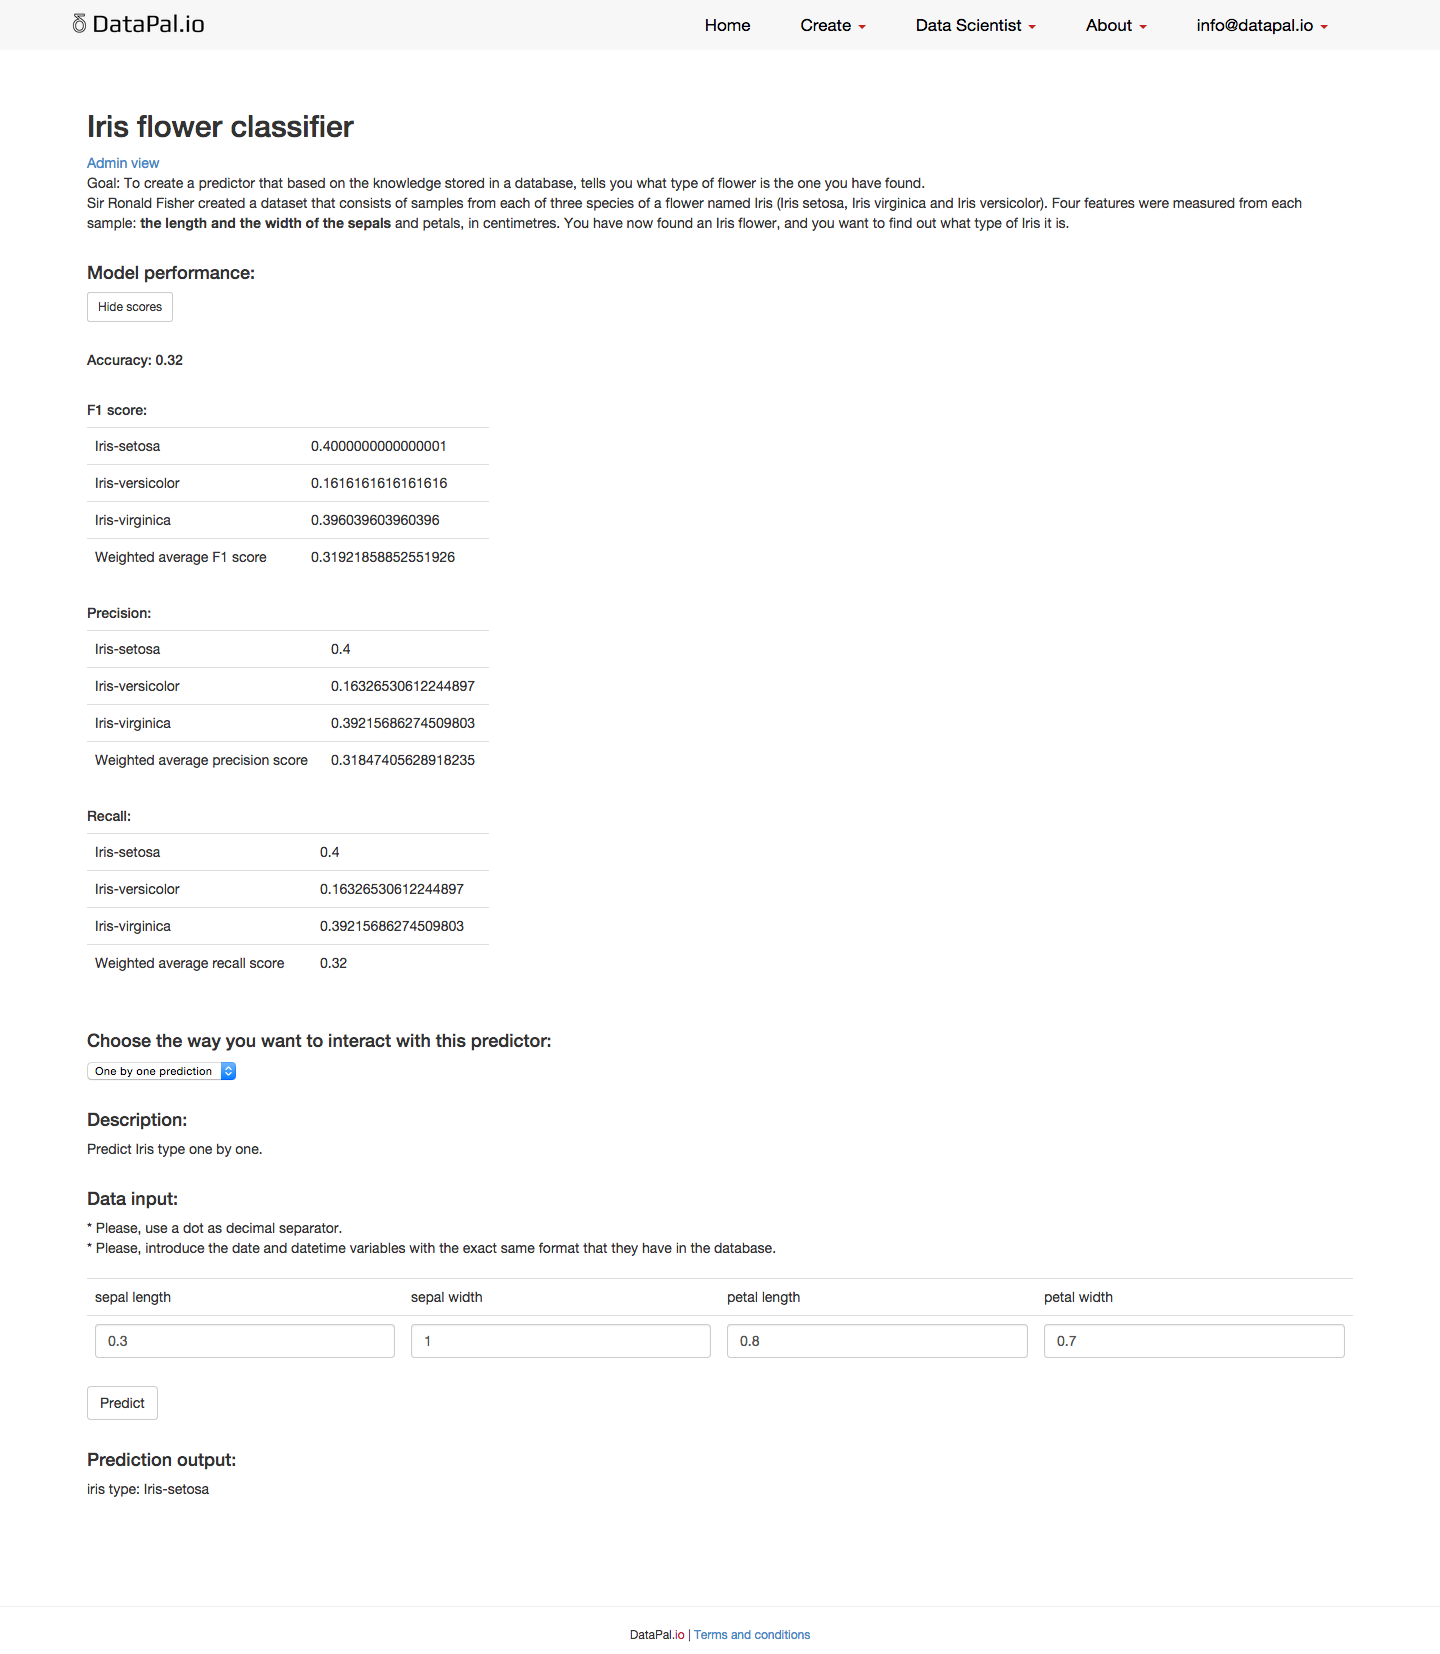

In [8]:
from IPython.display import Image
Image(filename='./iris_interface.png')

## Example 2: Bank Marketing predictor

This predictor is based in the dataset available in: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The model will predict if a client will purchase the product or not. The possible outputs are "yes" or "no".

### Source code:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.feature_extraction import DictVectorizer
import json
import os

class BankModel:

    
    def predictors_ai_interface(self, **kwargs):
        
        """
        This is the method used by Predictors.ai to interact with the model.
        
        Inputs:
                
        - pipe_id (integer): id of the pipe that has to be used.
        
        - input_data (dictionary): dictionary that contains the input data. The keys of the dictionary 
        correspond to the names of the inputs specified in models_definition.json for the selected pipe.
        Each key has an associated value. For the input variables the associated value is the value
        of the variable, whereas for the input files the associated value is its filename. 
        
        - input_files_dir (string): Relative path of the directory where the input files are stored
        (the algorithm has to read the input files from there).

        - output_files_dir (string): Relative path of the directory where the output files must be stored
        (the algorithm must store the output files in there).
        
        Outputs:
        
        - output_data (dictionary): dictionary that contains the output data. The keys of the dictionary 
        correspond to the names of the outputs specified in models_definition.json for the selected pipe. 
        Each key has an associated value. For the output variables the associated value is the value
        of the variable, whereas for the output files the associated value is its filename.  

        """
            
        pipe_id = kwargs['pipe_id']
        input_data = kwargs['input_data']
        input_files_dir = kwargs['input_files_dir']
        output_files_dir = kwargs['output_files_dir']
        
        output_data = self.train_or_predict(pipe_id, input_data, input_files_dir, output_files_dir)
        
        return output_data
        

    def train_or_predict(self, pipe_id, input_data, input_files_dir, output_files_dir):
        
        """
        Handles user requests.
        
        """
            
        if pipe_id in [0,1]:
            # load data
            # if one by one predictions
            if pipe_id == 0:

                # put all the input variables into a list to be able to easly construct the DataFrame
                for key in input_data.keys():
                    input_data[key] = [input_data[key]]

                # transform the input data to a DataFrame
                input_data_df = pd.DataFrame.from_dict(input_data)

                # encode input data
                one_hot_encoded_df, vecData = self.one_hot_dataframe_given_dv(input_data_df, self.categorical_features, self.featureEncoder, replace=True) 
                data = one_hot_encoded_df[self.post_processing_feature_names].values

            elif pipe_id == 1:
                # if bulk predictions
                data, data_args = self.load_input_files(input_files_dir=input_files_dir, input_data=input_data, training_data=False)
                data = data["features"]

            # make prediction
            prediction, out_args = self.predict(features=data)

            # decode prediction
            prediction = self.inverse_binarize_array(prediction)

            # return answer
            if pipe_id == 0:
                output_data = {}
                output_data[self.target_name] = prediction[0]
                return output_data

            elif pipe_id == 1:
                # save output in csv file and return it
                filename = 'predictions.csv'
                filepath = os.path.join(output_files_dir, filename)
                df = data_args['original_data_df']
                df[self.target_name] = prediction
                df.to_csv(filepath, index=False)
                output_data = {}
                output_data["file with predictions"] = filename
                return output_data
            else:
                return
        
        if pipe_id == 2:

            # load data
            data, data_args = self.load_input_files(input_files_dir=input_files_dir, input_data=input_data, training_data=True)

            # find best hyperparameters and fit model
            predictor, out_args = self.find_best_parameters_and_get_fitted_model(data=data, set_predictor_after_training=True)
            # set fitted predictor as the default for the DPModel
            self.predictor = predictor

            # save the label encoder
            self.featureEncoder = data_args['featureEncoder']

            # get unbiased predictions on training data
            y_true, y_pred, unbiased_prediction_args = self.get_unbiased_predictions_on_training_data(data=data)

            output_data = {}

            # save model_configuration.json
            model_definition, out_args = self.get_model_definition(data_args=data_args)
            path = os.path.join(output_files_dir, "model_definition.json")
            self.save_json_file(dict_to_save=model_definition, path=path)
            output_data["model_definition"] = 'model_definition.json'

            # save scores.json
            scores, out_args = self.get_scores(data=data, true_values=y_true, predicted_values=y_pred, data_args=data_args)
            path = os.path.join(output_files_dir, "scores.json")
            self.save_json_file(dict_to_save=scores, path=path)
            output_data["scores"] = 'scores.json'

            return output_data

        else:
            return


    def load_input_files(self, **kwargs):
        
        """
        Loads both files containing training data and data for prediction. 
        
        Encodes the target labels to integers. 
        
        In case the it is training data, it will return in the output args the 
        LabelEncoder used to encode the target labels to integers. We return it 
        instead of directly storing it, because it will be saved in case the training
        ends without errors.
        
        """
        
        input_data = kwargs['input_data']
        input_files_dir = kwargs['input_files_dir']
        
        input_file_path = input_files_dir + input_data['database']
        df = pd.read_csv(input_file_path, sep=";")
        
        training_data = kwargs.pop('training_data', False)
        
        # if we are loading training data, we have to assign an integer to each possible
        # categorical variable in the dataset. We do it by fitting a LabelEncoder for each
        # one of them.
        if training_data:
            out_args = {}
            out_args['original_data_df'] = df
            
            target_name = "success"
            feature_names = list(df.columns)
            
            feature_names.remove(target_name)
            self.feature_names = feature_names
            self.target_name = target_name
            
            self.categorical_features = ['job',
                         'marital',
                         'education',
                         'default',
                         'housing',
                         'loan',
                         'contact',
                         'previous outcome']
            
            # make one hot encoding in features
            one_hot_encoded_df, vecData, vec = self.one_hot_dataframe(df, self.categorical_features, replace=True)
            
            # encode target variable to integers
            df[self.target_name] = self.binarize_array(np.array(df[self.target_name]), "yes", "no")
               
            # return encoded features and targets and both encoders
            post_processing_feature_names = list(one_hot_encoded_df.columns)
            post_processing_feature_names.remove(self.target_name)
            self.post_processing_feature_names = post_processing_feature_names
            
            data = {}
            data['features'] = one_hot_encoded_df[post_processing_feature_names].values
            data['targets'] = np.array(df[self.target_name])

            out_args['featureEncoder'] = vec
            
            return data, out_args

        # if the data is for making predictions, we have to transform the categorical
        # features to integers by using the stored LabelEncoder.
        else:

            one_hot_encoded_df, vecData = self.one_hot_dataframe_given_dv(df, self.categorical_features, self.featureEncoder, replace=True) 
            data = {}
            # ensure that the columns are in the correct order
            data['features'] = one_hot_encoded_df[self.post_processing_feature_names].values
            
            out_args = {}
            out_args['original_data_df'] = df
        
            return data, out_args
    
    
    def find_best_parameters_and_get_fitted_model(self, **kwargs):
        
        """
        Finds the best set of hyperparameters for a Random Forest for the provided data. 
        The best hyperparameters are found by repeatedly drawing random samples from a distribution 
        of parameters and evaluating them by using cross validation.        
        
        """
        
        # load data
        data = kwargs['data']
        X = data['features']
        y = data['targets']
        out_args = {}
        
        # we choose Random Fores Classifier as the Machine Learning algorithm for
        # this DPModel.
        rc = RandomForestClassifier()
        
        # here we define the space of parameters over which we want to perform the random search
        param_distributions = {}
        param_distributions["n_estimators"] = [50, 100, 150]

        # do random search
        random_search_outer = RandomizedSearchCV(rc, param_distributions=param_distributions,
            cv=5, n_iter=3)
        random_search_outer.fit(X, y)
            
        predictor = random_search_outer.best_estimator_

        return predictor, out_args
        

    def predict(self, **kwargs):
        
        """
        Makes predictions using the stored predictor of the DPModel.
        
        """
    
        features = kwargs['features']
        predictor = kwargs.pop('predictor', self.predictor)
        
        X = features
        prediction = predictor.predict(X)
        
        out_args = {}
        
        return prediction, out_args


    def get_unbiased_predictions_on_training_data(self, **kwargs):
        
        """
        This method provides unbiased predictions for all our training samples.
        We accomplish that by performing a nested cross validation:
        We leave a hold out set out, and we past the rest of the data to the 
        find_best_parameters_and_get_fitted_model method, which contains a cross validation itself. 
        Then we make predictions on the hold out set with the resulted predictor. This way, we found
        the best hyperparameters without using the hold out data. We repeat this process leaving out 
        different training samples each time by performing a cross validation.
        
        """
        
        data = kwargs['data']
        
        y_true = None
        y_pred = None
        out_args = {}
        
        X = np.array(data['features'])
        y = np.array(data['targets'])
        out_args = {}
        
        # make unbiased predictions using nested CV
        # We will use this unbiased predictions in order to calculate the performance of the
        # algorithm using multiple scores.
        cv = StratifiedKFold(y, n_folds=5, shuffle=True)
        for i, (train, test) in enumerate(cv):
            
            data_fold = {}
            data_fold['features'] = X[train]
            data_fold['targets'] = y[train]
                        
            predictor, out_args = self.find_best_parameters_and_get_fitted_model(data=data_fold, set_predictor_after_training=False)
            y_test_pred, out_args = self.predict(predictor=predictor, features=X[test])
            
            if y_true == None:
                y_true = y[test]
                y_pred = y_test_pred
            else:
                y_true = np.hstack((y_true, y[test]))
                y_pred = np.hstack((y_pred, y_test_pred))

        return y_true, y_pred, out_args
    
    
    def get_model_definition(self, **kwargs):
        
        """
        Returns model_definition.json dictionary.
        
        """

        model_definition = {}
        model_definition["name"] = "Sales predictor"
        model_definition["schema_version"] = "0.02"
        model_definition["environment_name"] = "python2.7.9_June14th2015"
        model_definition["description"] = "Based on historical sales data, this predictor " \
                                          "predicts whether a new potential customer will " \
                                          "buy the product or not."
        model_definition["retraining_allowed"] = True
        model_definition["base_algorithm"] = "Random Forest Classifier"     
        model_definition["score_minimized"] = "gini"        

        pipes, out_args = self.get_pipes(**kwargs)
        model_definition["pipes"] = pipes
        
        out_args = {}
        
        return model_definition, out_args
    
    
    def get_pipes(self, **kwargs):
        
        """
        Returns pipes dictionary.
        
        """
        
        df = kwargs['data_args']['original_data_df']
        
        # One by one prediction pipe

        dicts_predicting_inputs = []
        for col in self.feature_names:
            d = {}
            d["name"] = col
            d["type"] = "variable"
            d["required"] = True
            if df[col].dtype == "O":
                d["values"] = list(set(df[col]))
                d["variable_type"] = "string"
            elif df[col].dtype == "int":
                d["variable_type"] = "integer"
            elif df[col].dtype == "float":
                d["variable_type"] = "float"

            dicts_predicting_inputs.append(d)

        dicts_predicting_outputs = []
        for col in [self.target_name]:
            d = {}
            d["name"] = col
            d["type"] = "variable"
            d["required"] = True
            if df[col].dtype == "O":
                d["values"] = list(set(df[col]))
                d["variable_type"] = "string"
            elif df[col].dtype == "int":
                d["variable_type"] = "integer"
            elif df[col].dtype == "float":
                d["variable_type"] = "float"

            dicts_predicting_outputs.append(d)

        pipes = []

        pipe = {}
        pipe["id"] = 0
        pipe["action"] = "predict"
        pipe["name"] = "One by one prediction"
        pipe["description"] = "Make predictions one by one."
        pipe["inputs"] = dicts_predicting_inputs
        pipe["outputs"] = dicts_predicting_outputs
        pipes.append(pipe)


        # Bulk prediction pipe

        pipe = {
            "id": 1,
            "action": "predict",
            "name":"Bulk prediction",
            "description": "Upload csv file.",
            "inputs": [
                {
                    "name": "database",
                    "type": "file",
                    "extensions": ["csv"],
                    "required": True
                }
            ],
            "outputs": [
                {
                    "name": "file with predictions",
                    "type": "file",
                    "extensions": ["csv"]
                }
            ]
        }

        pipes.append(pipe)


        # Training pipe

        pipe = {
            "id": 2,
            "action": "train",
            "name":"Training pipe",
            "description": "Upload database with target labels.",
            "inputs": [
                {
                    "name": "database",
                    "type": "file",
                    "extensions": ["csv"],
                    "required": True
                }
            ],
            "outputs": [
                {
                    "name": "model_definition",
                    "type": "file",
                    "filenames": ["model_definition.json"]
                },
                {
                    "name": "scores",
                    "type": "file",
                    "filenames": ["scores.json"]
                }
            ]
        }
            
        pipes.append(pipe)
        out_args = {}
        
        return pipes, out_args

    
    def get_scores(self, **kwargs):
        
        """
        Calculate scores.
        
        """
        
        data = kwargs['data']
        true_values = kwargs['true_values']
        predicted_values = kwargs['predicted_values']

        out_args = {}
        scores = []

        sc = accuracy_score (true_values, predicted_values)
        score = {}
        score['name'] = 'Accuracy'
        score['value'] = sc
        scores.append(score)        
        
        sc = f1_score(true_values, predicted_values)
        score = {}
        score['name'] = 'F1 score'
        score['value'] = sc
        scores.append(score)
        
        sc = precision_score(true_values, predicted_values)
        score = {}
        score['name'] = 'Precision'
        score['value'] = sc
        scores.append(score)
        
        sc = recall_score(true_values, predicted_values)
        score = {}
        score['name'] = 'Recall'
        score['value'] = sc
        scores.append(score)
        
        scores_out = {}
        scores_out["scores"] = scores
        scores_out["schema_version"] = "0.02"
        
        return scores_out, out_args
    
    
    def save_json_file(self, **kwargs):
        

        """
        Saves dictionary in path.
        
        """
        
        dict_to_save = kwargs["dict_to_save"]
        path = kwargs["path"]
        with open(path,'wb') as fp:
            json.dump(dict_to_save, fp)
            
        return
    

    def one_hot_dataframe(self, data, cols, replace=False):
        """ 
        Takes a dataframe and a list of columns that need to be encoded.
        Returns a 3-tuple comprising the data, the vectorized data,
        and the fitted vectorizor.

        """
        vec = DictVectorizer()
        mkdict = lambda row: dict((col, row[col]) for col in cols)
        vecData = pd.DataFrame(vec.fit_transform(data[cols].to_dict(outtype='records')).toarray())
        vecData.columns = vec.get_feature_names()
        vecData.index = data.index
        if replace is True:
            data = data.drop(cols, axis=1)
            data = data.join(vecData)
        return (data, vecData, vec)


    def one_hot_dataframe_given_dv(self, data, cols, dv, replace=False):
        """ 
        Takes a dataframe, a list of columns and a DictVectorizer and
        encodes those columns according to the info in the DictVectorizer.
        Returns a 2-tuple comprising the data, and the vectorized data.

        """
        vecData = pd.DataFrame(dv.transform(data[cols].to_dict(outtype='records')).toarray())
        vecData.columns = dv.get_feature_names()
        vecData.index = data.index
        if replace is True:
            data = data.drop(cols, axis=1)
            data = data.join(vecData)
        return (data, vecData)
    
    
    def binarize_array(self, array_to_transform, positive_label, negative_label):
        """
        Converts the given column to 0s and 1s.
        Specially when the converted column is the target one, it is important
        to controll which label becomes 0 and which one becomes 1, in order to
        provide the correct values of precision, recall, specificity, and so on.
        
        """
        
        array_to_transform[array_to_transform == positive_label] = 1
        array_to_transform[array_to_transform == negative_label] = 0
        array_to_transform = array_to_transform.astype(int)
        self.positive_label = positive_label
        self.negative_label = negative_label
        
        return array_to_transform
    
    
    def inverse_binarize_array(self, array_to_transform):
        """
        Converts the given column to 0s and 1s.
        Specially when the converted column is the target one, it is important
        to controll which label becomes 0 and which one becomes 1, in order to
        provide the correct values of precision, recall, specificity, and so on.
        
        """
        
        # important to do the comparisson before changing the data type of the array.
        pos_with_1 = (array_to_transform == 1)
        pos_with_0 = (array_to_transform == 0)
        array_to_transform = array_to_transform.astype(str)
        array_to_transform[pos_with_1] = self.positive_label
        array_to_transform[pos_with_0] = self.negative_label
        
        return array_to_transform

### Training the model:

In [2]:
# this is how predictors.ai trains your model

# create model object
model = BankModel()

# load data and train
pipe_id = 2
input_data = {}
input_data["database"] = "bank.csv"
input_files_dir = "./input_dir_bank/"
output_files_dir = "./output_dir_bank/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data, input_files_dir=input_files_dir,
                                        output_files_dir=output_files_dir)
print output_data

# save trained model
import cPickle as pickle
with open("./output_dir_bank/bank.pk",'wb') as fp:
    pickle.dump(model, fp, pickle.HIGHEST_PROTOCOL)

{'model_definition': 'model_definition.json', 'scores': 'scores.json'}


/Users/user/PYTHON_VIRTUAL_ENV/lib/python2.7/site-packages/IPython/kernel/__main__.py:308: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### Verify that the JSON files generated follow their corresponding schema:

In [3]:
from jsonschema import validate
import json

with open("json_schemas/model_definition_schema_v002.json", "r") as f:
    model_definition_schema = json.load(f)
    
with open("output_dir_bank/model_definition.json", "r") as f:
    model_definition = json.load(f)
    
validate(model_definition, model_definition_schema)


with open("json_schemas/scores_schema_v002.json", "r") as f:
    scores_schema = json.load(f)
    
with open("output_dir_bank/scores.json", "r") as f:
    scores = json.load(f)
    
validate(scores, scores_schema)

### Making predictions:

In [4]:
# this is how predictors.ai makes predictions using your model

# load data and predict
pipe_id = 0
input_data = {}
input_data["age"] = "41"
input_data["job"] = "services"
input_data["marital"] = "married"
input_data["education"] = "primary"
input_data["default"] = "no"
input_data["balance"] = "2000"
input_data["housing"] = "no"
input_data["loan"] = "yes"
input_data["contact"] = "cellular"
input_data["days since last contact"] = "233"
input_data["number previous contacts"] = "3"
input_data["previous outcome"] = "failure"
input_files_dir = "./input_dir_bank/"
output_files_dir = "./output_dir_bank/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data, input_files_dir=input_files_dir, 
                                          output_files_dir=output_files_dir)

print output_data

{'success': 'no'}


In [5]:
# this is how predictors.ai makes predictions using your model

# load data and predict
pipe_id = 1
input_data = {}
input_data["database"] = "bank_without_target.csv"
input_files_dir = "./input_dir_bank/"
output_files_dir = "./output_dir_bank"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_files_dir=input_files_dir, input_data=input_data,
                                        output_files_dir=output_files_dir)

print output_data

{'file with predictions': 'predictions.csv'}


### User interface generated by Predictors.ai:

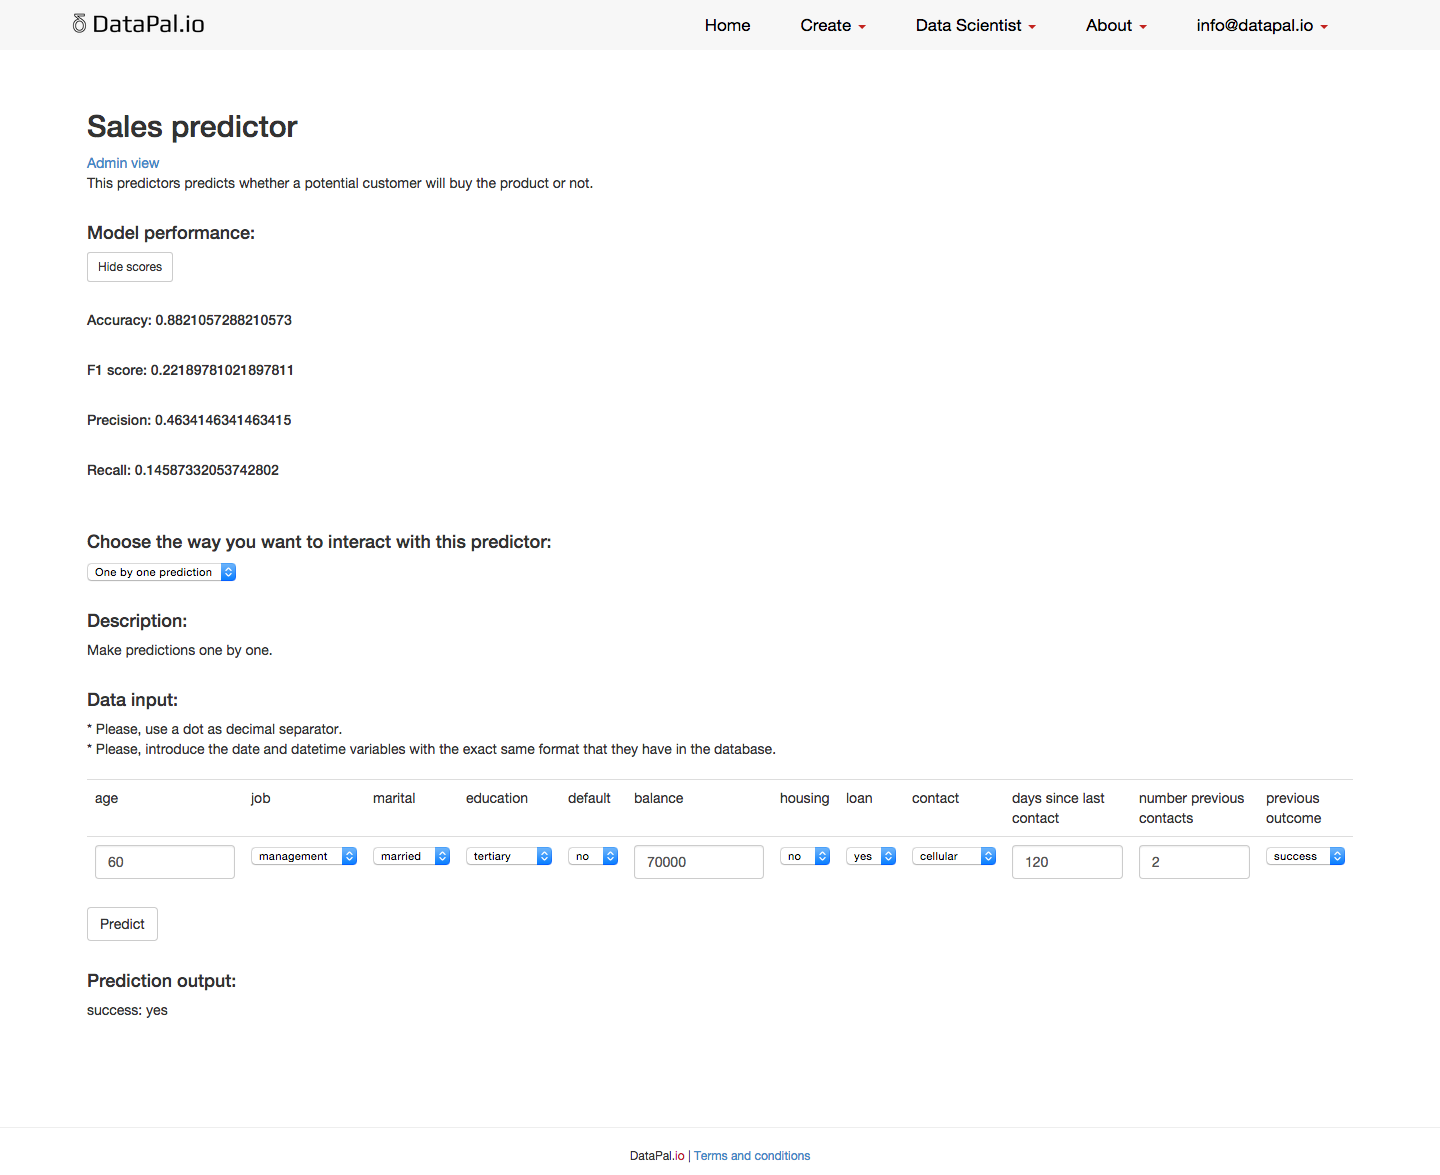

In [6]:
from IPython.display import Image
Image(filename='./bank_interface.png')

## Example 3: Bank Marketing predictor (predicting probabilities)

This predictor is based in the dataset available in: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

This time, the model will predict the probability of a client purchasing the product. We will show how to generate the Area under the ROC curve and the Area under precision-recall curve.

### Source code:

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, auc
from sklearn.feature_extraction import DictVectorizer
import json
import os
import copy

class BankProbModel:

    
    def predictors_ai_interface(self, **kwargs):
        
        """
        This is the method used by Predictors.ai to interact with the model.
        
        Inputs:
                
        - pipe_id (integer): id of the pipe that has to be used.
        
        - input_data (dictionary): dictionary that contains the input data. The keys of the dictionary 
        correspond to the names of the inputs specified in models_definition.json for the selected pipe.
        Each key has an associated value. For the input variables the associated value is the value
        of the variable, whereas for the input files the associated value is its filename. 
        
        - input_files_dir (string): Relative path of the directory where the input files are stored
        (the algorithm has to read the input files from there).

        - output_files_dir (string): Relative path of the directory where the output files must be stored
        (the algorithm must store the output files in there).
        
        Outputs:
        
        - output_data (dictionary): dictionary that contains the output data. The keys of the dictionary 
        correspond to the names of the outputs specified in models_definition.json for the selected pipe. 
        Each key has an associated value. For the output variables the associated value is the value
        of the variable, whereas for the output files the associated value is its filename.  

        """
            
        pipe_id = kwargs['pipe_id']
        input_data = kwargs['input_data']
        input_files_dir = kwargs['input_files_dir']
        output_files_dir = kwargs['output_files_dir']

        output_data = self.train_or_predict(pipe_id, input_data, input_files_dir, output_files_dir)
        
        return output_data
        
    
    def train_or_predict(self, pipe_id, input_data, input_files_dir, output_files_dir):
        
        """
        Handles user requests.
        
        """
            
        if pipe_id in [0,1]:
            # load data
            # if one by one predictions
            if pipe_id == 0:

                # put all the input variables into a list to be able to easly construct the DataFrame
                for key in input_data.keys():
                    input_data[key] = [input_data[key]]

                # transform the input data to a DataFrame
                input_data_df = pd.DataFrame.from_dict(input_data)

                # encode input data
                one_hot_encoded_df, vecData = self.one_hot_dataframe_given_dv(input_data_df, self.categorical_features, self.featureEncoder, replace=True) 
                data = one_hot_encoded_df[self.post_processing_feature_names].values

            elif pipe_id == 1:
                # if bulk predictions
                data, data_args = self.load_input_files(input_files_dir=input_files_dir, input_data=input_data, training_data=False)
                data = data["features"]

            # make prediction
            prediction, out_args = self.predict(features=data)

            # return answer
            if pipe_id == 0:
                output_data = {}
                output_data[self.target_name] = prediction[0]
                return output_data

            elif pipe_id == 1:
                # save output in csv file and return it
                filename = 'predictions.csv'
                filepath = os.path.join(output_files_dir, filename)
                df = data_args['original_data_df']
                df[self.target_name] = prediction
                df.to_csv(filepath, index=False)
                output_data = {}
                output_data["file with predictions"] = filename
                return output_data
            else:
                return
        
        if pipe_id == 2:

            # load data
            data, data_args = self.load_input_files(input_files_dir=input_files_dir, input_data=input_data, training_data=True)

            # find best hyperparameters and fit model
            predictor, out_args = self.find_best_parameters_and_get_fitted_model(data=data, set_predictor_after_training=True)
            # set fitted predictor as the default for the DPModel
            self.predictor = predictor

            # save the label encoder
            self.featureEncoder = data_args['featureEncoder']

            # get unbiased predictions on training data
            y_true, y_pred, unbiased_prediction_args = self.get_unbiased_predictions_on_training_data(data=data)

            output_data = {}

            # save model_configuration.json
            model_definition, out_args = self.get_model_definition(data_args=data_args)
            path = os.path.join(output_files_dir, "model_definition.json")
            self.save_json_file(dict_to_save=model_definition, path=path)
            output_data["model_definition"] = 'model_definition.json'

            # save scores.json
            scores, out_args = self.get_scores(data=data, true_values=y_true, predicted_values=y_pred, data_args=data_args)
            path = os.path.join(output_files_dir, "scores.json")
            self.save_json_file(dict_to_save=scores, path=path)
            output_data["scores"] = 'scores.json'

            return output_data

        else:
            return
        
        
    def load_input_files(self, **kwargs):
        
        """
        Loads both files containing training data and data for prediction. 
        
        Encodes the target labels to integers. 
        
        In case the it is training data, it will return in the output args the 
        LabelEncoder used to encode the target labels to integers. We return it 
        instead of directly storing it, because it will be saved in case the training
        ends without errors.
        
        """
        
        input_data = kwargs['input_data']
        input_files_dir = kwargs['input_files_dir']
        
        input_file_path = input_files_dir + input_data['database']
        df = pd.read_csv(input_file_path, sep=";")
        
        training_data = kwargs.pop('training_data', False)
        
        # if we are loading training data, we have to assign an integer to each possible
        # categorical variable in the dataset. We do it by fitting a LabelEncoder for each
        # one of them.
        if training_data:
            out_args = {}
            out_args['original_data_df'] = df
            
            target_name = "success"
            feature_names = list(df.columns)
            
            feature_names.remove(target_name)
            self.feature_names = feature_names
            self.target_name = target_name
            
            self.categorical_features = ['job',
                         'marital',
                         'education',
                         'default',
                         'housing',
                         'loan',
                         'contact',
                         'previous outcome']
            
            # make one hot encoding in features
            one_hot_encoded_df, vecData, vec = self.one_hot_dataframe(df, self.categorical_features, replace=True)
            
            # encode target variable to integers
            df[self.target_name] = self.binarize_array(np.array(df[self.target_name]), "yes", "no")
               
            # return encoded features and targets and both encoders
            post_processing_feature_names = list(one_hot_encoded_df.columns)
            post_processing_feature_names.remove(self.target_name)
            self.post_processing_feature_names = post_processing_feature_names
            
            data = {}
            data['features'] = one_hot_encoded_df[post_processing_feature_names].values
            data['targets'] = np.array(df[self.target_name])

            out_args['featureEncoder'] = vec
            
            return data, out_args

        # if the data is for making predictions, we have to transform the categorical
        # features to integers by using the stored LabelEncoder.
        else:

            one_hot_encoded_df, vecData = self.one_hot_dataframe_given_dv(df, self.categorical_features, self.featureEncoder, replace=True) 
            data = {}
            # ensure that the columns are in the correct order
            data['features'] = one_hot_encoded_df[self.post_processing_feature_names].values
            
            out_args = {}
            out_args['original_data_df'] = df
        
            return data, out_args

    
    def find_best_parameters_and_get_fitted_model(self, **kwargs):
        
        """
        Finds the best set of hyperparameters for a Random Forest for the provided data. 
        The best hyperparameters are found by repeatedly drawing random samples from a distribution 
        of parameters and evaluating them by using cross validation.
        
        """
        
        # load data
        data = kwargs['data']
        X = data['features']
        y = data['targets']
        out_args = {}
        
        # we choose Random Fores Classifier as the Machine Learning algorithm for
        # this DPModel.
        rc = RandomForestClassifier()
        
        # here we define the space of parameters over which we want to perform the random search
        param_distributions = {}
        param_distributions["n_estimators"] = [50, 100, 150]

        # do random search
        random_search_outer = RandomizedSearchCV(rc, param_distributions=param_distributions,
            cv=5, n_iter=3)
        random_search_outer.fit(X, y)
            
        predictor = random_search_outer.best_estimator_

        return predictor, out_args
        

    def predict(self, **kwargs):
        
        """
        Makes predictions using the stored predictor of the DPModel.
        
        """
    
        features = kwargs['features']
        predictor = kwargs.pop('predictor', self.predictor)
        
        X = features
        prediction = predictor.predict_proba(X)[:,1]
        
        out_args = {}
        
        return prediction, out_args


    def get_unbiased_predictions_on_training_data(self, **kwargs):
        
        """
        This method provides unbiased predictions for all our training samples.
        We accomplish that by performing a nested cross validation:
        We leave a hold out set out, and we past the rest of the data to the 
        find_best_parameters_and_get_fitted_model method, which contains a cross validation itself. 
        Then we make predictions on the hold out set with the resulted predictor. This way, we found
        the best hyperparameters without using the hold out data. We repeat this process leaving out 
        different training samples each time by performing a cross validation.
        
        """
        
        data = kwargs['data']
        
        y_true = None
        y_pred = None
        out_args = {}
        
        X = np.array(data['features'])
        y = np.array(data['targets'])
        out_args = {}
        
        # make unbiased predictions using nested CV
        # We will use this unbiased predictions in order to calculate the performance of the
        # algorithm using multiple scores.
        cv = StratifiedKFold(y, n_folds=5, shuffle=True)
        for i, (train, test) in enumerate(cv):
            
            data_fold = {}
            data_fold['features'] = X[train]
            data_fold['targets'] = y[train]
                        
            predictor, out_args = self.find_best_parameters_and_get_fitted_model(data=data_fold, set_predictor_after_training=False)
            y_test_pred, out_args = self.predict(predictor=predictor, features=X[test])

            if y_true == None:
                y_true = y[test]
                y_pred = y_test_pred
            else:
                y_true = np.hstack((y_true, y[test]))
                y_pred = np.hstack((y_pred, y_test_pred))

        return y_true, y_pred, out_args
    
    
    def get_model_definition(self, **kwargs):
        
        """
        Returns model_definition.json dictionary.
        
        """

        model_definition = {}
        model_definition["name"] = "Sales predictor (probabilities)"
        model_definition["schema_version"] = "0.02"
        model_definition["environment_name"] = "python2.7.9_June14th2015"
        model_definition["description"] = "Based on historical sales data, this predictor provides " \
                                          "the probability (from 0 to 1) that a new potential customer " \
                                          "purchases our product."
        model_definition["retraining_allowed"] = True
        model_definition["base_algorithm"] = "Random Forest Classifier"     
        model_definition["score_minimized"] = "gini"        
        
        pipes, out_args = self.get_pipes(**kwargs)
        model_definition["pipes"] = pipes
        
        out_args = {}
        
        return model_definition, out_args
    
    
    def get_pipes(self, **kwargs):
        
        """
        Returns pipes.json dictionary.
        
        """
        
        df = kwargs['data_args']['original_data_df']
        
        # generate the one by one prediction pipes

        dicts_predicting_inputs = []
        for col in self.feature_names:
            d = {}
            d["name"] = col
            d["type"] = "variable"
            d["required"] = True
            if df[col].dtype == "O":
                d["values"] = list(set(df[col]))
                d["variable_type"] = "string"
            elif df[col].dtype == "int":
                d["variable_type"] = "integer"
            elif df[col].dtype == "float":
                d["variable_type"] = "float"

            dicts_predicting_inputs.append(d)

        dicts_predicting_outputs = []
        col = self.target_name
        d = {}
        d["name"] = col
        d["type"] = "variable"
        d["required"] = True
        d["variable_type"] = "float"
        d["binary_decision"] = {
                'positive_label': self.positive_label,
                'negative_label': self.negative_label,
                'threshold': 'interactive_from_scores'
            }
        dicts_predicting_outputs.append(d)

        pipes = []

        pipe = {}
        pipe["id"] = 0
        pipe["action"] = "predict"
        pipe["name"] = "One by one prediction"
        pipe["description"] = "Make predictions one by one."
        pipe["inputs"] = dicts_predicting_inputs
        pipe["outputs"] = dicts_predicting_outputs
        pipes.append(pipe)


        # add manually the bulk predictions pipes

        pipe = {
            "id": 1,
            "action": "predict",
            "name":"Bulk prediction",
            "description": "Upload csv file.",
            "inputs": [
                {
                    "name": "database",
                    "type": "file",
                    "extensions": ["csv"],
                    "required": True
                }
            ],
            "outputs": [
                {
                    "name": "file with predictions",
                    "type": "file",
                    "extensions": ["csv"]
                }
            ]
        }

        pipes.append(pipe)


        # add manually training pipes

        pipe = {
            "id": 2,
            "action": "train",
            "name":"Training pipe",
            "description": "Upload database with target labels.",
            "inputs": [
                {
                    "name": "database",
                    "type": "file",
                    "extensions": ["csv"],
                    "required": True
                }
            ],
            "outputs": [
                {
                    "name": "model_definition",
                    "type": "file",
                    "filenames": ["model_definition.json"]
                },
                {
                    "name": "scores",
                    "type": "file",
                    "filenames": ["scores.json"]
                }
            ]
        }
            
        pipes.append(pipe)
        
        out_args = {}
        
        return pipes, out_args

    
    def get_scores(self, **kwargs):
        
        """
        Calculate scores.
        
        """
        
        data = kwargs['data']
        true_values = kwargs['true_values']
        predicted_values = kwargs['predicted_values']

        out_args = {}
        scores = []
                
        df_curves, auroc, auprc = self.get_curves(true_values, predicted_values)
        # get also curves for random predictions
        df_curves_random, auroc_random, auprc_random = self.get_curves(true_values, np.random.rand(len(true_values)))
        
        roc_curve = {
                "name": "Area under the ROC curve",
                "value": auroc,
                "associated_values": [
                    {
                        "name": "Area under the ROC curve for random predictions",
                        "value": 0.5
                    }
                ],
                "associated_plots": [
                    {
                        "horizontal_axis": {
                            "name": "Sensibility"
                        },
                        "vertical_axis": {
                            "name": "1 - Specificity"
                        },
                        "curves": [
                            {
                                "name": "ROC curve",
                                "horizontal_axis_values": list(np.round(df_curves.fpr,3)),
                                "vertical_axis_values": list(np.round(df_curves.recall,3)),
                                "info_associated_to_each_point": {
                                    "thresholds": list(np.round(df_curves.threshold,3))
                                }
                            },
                            {
                                "name": "Random",
                                "horizontal_axis_values": [0, 0.5, 1],
                                "vertical_axis_values": [0, 0.5, 1]
                            }  
                        ]
                    }
                ]
            }
        scores.append(roc_curve)

        pr_curve = {
                "name": "Area under the precision-recall curve",
                "value": auprc,
                "associated_values": [
                    {
                        "name": "Area under the precision-recall curve for random predictions",
                        "value": auprc_random
                    }
                ],
                "associated_plots": [
                    {
                        "horizontal_axis": {
                            "name": "Recall"
                        },
                        "vertical_axis": {
                            "name": "Precision"
                        },
                        "curves": [
                            {
                                "name": "Precision-Recall curve",
                                "horizontal_axis_values": list(np.round(df_curves.recall,3)),
                                "vertical_axis_values": list(np.round(df_curves.precision,3)),
                                "info_associated_to_each_point": {
                                    "thresholds": list(np.round(df_curves.threshold,3))
                                }
                            },
                            {
                                "name": "Random",
                                "horizontal_axis_values": list(np.round(df_curves_random.recall,3)),
                                "vertical_axis_values": list(np.round(df_curves_random.precision,3))
                            }  
                        ]
                    }
                ]
            }
        scores.append(pr_curve)
        
        scores_out = {}
        scores_out["scores"] = scores
        scores_out["schema_version"] = "0.02"
        
        return scores_out, out_args
    
    
    def save_json_file(self, **kwargs):
        

        """
        Saves dictionary in path.
        
        """
        
        dict_to_save = kwargs["dict_to_save"]
        path = kwargs["path"]
        with open(path,'wb') as fp:
            json.dump(dict_to_save, fp)
            
        return
    

    def one_hot_dataframe(self, data, cols, replace=False):
        """ 
        Takes a dataframe and a list of columns that need to be encoded.
        Returns a 3-tuple comprising the data, the vectorized data,
        and the fitted vectorizor.

        """
        vec = DictVectorizer()
        mkdict = lambda row: dict((col, row[col]) for col in cols)
        vecData = pd.DataFrame(vec.fit_transform(data[cols].to_dict(outtype='records')).toarray())
        vecData.columns = vec.get_feature_names()
        vecData.index = data.index
        if replace is True:
            data = data.drop(cols, axis=1)
            data = data.join(vecData)
        return (data, vecData, vec)


    def one_hot_dataframe_given_dv(self, data, cols, dv, replace=False):
        """ 
        Takes a dataframe, a list of columns and a DictVectorizer and
        encodes those columns according to the info in the DictVectorizer.
        Returns a 2-tuple comprising the data, and the vectorized data.

        """
        vecData = pd.DataFrame(dv.transform(data[cols].to_dict(outtype='records')).toarray())
        vecData.columns = dv.get_feature_names()
        vecData.index = data.index
        if replace is True:
            data = data.drop(cols, axis=1)
            data = data.join(vecData)
        return (data, vecData)
    
    
    def binarize_array(self, array_to_transform, positive_label, negative_label):
        """
        Converts the given column to 0s and 1s.
        Specially when the converted column is the target one, it is important
        to controll which label becomes 0 and which one becomes 1, in order to
        provide the correct values of precision, recall, specificity, and so on.
        
        """
        
        array_to_transform[array_to_transform == positive_label] = 1
        array_to_transform[array_to_transform == negative_label] = 0
        array_to_transform = array_to_transform.astype(int)
        self.positive_label = positive_label
        self.negative_label = negative_label
        
        return array_to_transform
    
    
    def inverse_binarize_array(self, array_to_transform):
        """
        Converts the given column to 0s and 1s.
        Specially when the converted column is the target one, it is important
        to controll which label becomes 0 and which one becomes 1, in order to
        provide the correct values of precision, recall, specificity, and so on.
        
        """
        
        # important to do the comparisson before changing the data type of the array.
        pos_with_1 = (array_to_transform == 1)
        pos_with_0 = (array_to_transform == 0)
        array_to_transform = array_to_transform.astype(str)
        array_to_transform[pos_with_1] = self.positive_label
        array_to_transform[pos_with_0] = self.negative_label
        
        return array_to_transform


    def get_curves(self, true, predictions):

        """
        Returns pandas dataframe with the following columns:
        recall, precision, fpr, thresholds.

        It also returns the area under the ROC curve and the area under the
        precision-recall curve.

        """


        precision_values = []
        recall_values = []
        one_minus_specificity_values = []
        thresholds = []

        for threshold in np.sort(list(set(predictions))):

            new_pred = copy.deepcopy(predictions)
            new_pred[new_pred >= threshold] = 1
            new_pred[new_pred < threshold] = 0
            precision_values.append(precision_score(true, new_pred))
            recall_values.append(recall_score(true, new_pred))
            one_minus_specificity_values.append(1 - (self.specificity_score(true, new_pred)))
            thresholds.append(threshold)

        # we need to have the recall until value 0, in orther to draw the precision-recall curve
        # There will be situations in which, to achieve the recall 0 we need to predict every sample
        # as false. In that case, we arbitrarily set the precision to 1, although in reality is a
        # "0/0" division.
        if recall_values[-1] != 0:
            recall_values.append(0)
            one_minus_specificity_values.append(0)
            precision_values.append(1)
            thresholds.append(thresholds[-1] + 0.1)

        df = pd.DataFrame(index = thresholds)
        df["recall"] = recall_values
        df["precision"] = precision_values
        df["fpr"] = one_minus_specificity_values
        df["threshold"] = thresholds
        df = df.sort("threshold")

        auroc = auc(one_minus_specificity_values,recall_values)
        auprc = auc(recall_values,precision_values)

        return df, auroc, auprc


    def specificity_score(self, true_values, predicted_values):

        true_values = np.array(true_values)
        predicted_values = np.array(predicted_values)

        specificity = sum(predicted_values[true_values == 0] == 0) / float(len(predicted_values[true_values == 0]))

        return specificity

### Training the model:

In [2]:
# this is how predictors.ai trains your model

# create model object
model = BankProbModel()

# load data and train
pipe_id = 2
input_data = {}
input_data["database"] = "bank.csv"
input_files_dir = "./input_dir_bank_prob/"
output_files_dir = "./output_dir_bank_prob/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data, input_files_dir=input_files_dir,
                                        output_files_dir=output_files_dir)
print output_data

# save trained model
import cPickle as pickle
with open("./output_dir_bank_prob/bank_prob.pk",'wb') as fp:
    pickle.dump(model, fp, pickle.HIGHEST_PROTOCOL)

{'model_definition': 'model_definition.json', 'scores': 'scores.json'}


/Users/user/PYTHON_VIRTUAL_ENV/lib/python2.7/site-packages/IPython/kernel/__main__.py:306: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


### Verify that the JSON files generated follow their corresponding schema:

In [3]:
from jsonschema import validate
import json

with open("json_schemas/model_definition_schema_v002.json", "r") as f:
    model_definition_schema = json.load(f)
    
with open("output_dir_bank_prob/model_definition.json", "r") as f:
    model_definition = json.load(f)
    
validate(model_definition, model_definition_schema)


with open("json_schemas/scores_schema_v002.json", "r") as f:
    scores_schema = json.load(f)
    
with open("output_dir_bank_prob/scores.json", "r") as f:
    scores = json.load(f)
    
validate(scores, scores_schema)

### Making predictions:

In [4]:
# this is how predictors.ai makes predictions using your model

# load data and predict
pipe_id = 0
input_data = {}
input_data["age"] = "41"
input_data["job"] = "services"
input_data["marital"] = "married"
input_data["education"] = "primary"
input_data["default"] = "no"
input_data["balance"] = "2000"
input_data["housing"] = "no"
input_data["loan"] = "yes"
input_data["contact"] = "cellular"
input_data["days since last contact"] = "233"
input_data["number previous contacts"] = "3"
input_data["previous outcome"] = "failure"
input_files_dir = "./input_dir_bank_prob/"
output_files_dir = "./output_dir_bank_prob/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_data=input_data, input_files_dir=input_files_dir, 
                                          output_files_dir=output_files_dir)

print output_data

{'success': 0.10666666666666667}


In [5]:
# this is how predictors.ai makes predictions using your model

# load data and predict
pipe_id = 1
input_data = {}
input_data["database"] = "bank_without_target.csv"
input_files_dir = "./input_dir_bank_prob/"
output_files_dir = "./output_dir_bank_prob/"

output_data = model.predictors_ai_interface(pipe_id=pipe_id, input_files_dir=input_files_dir, input_data=input_data,
                                        output_files_dir=output_files_dir)

print output_data

{'file with predictions': 'predictions.csv'}


### User interface generated by Predictors.ai:

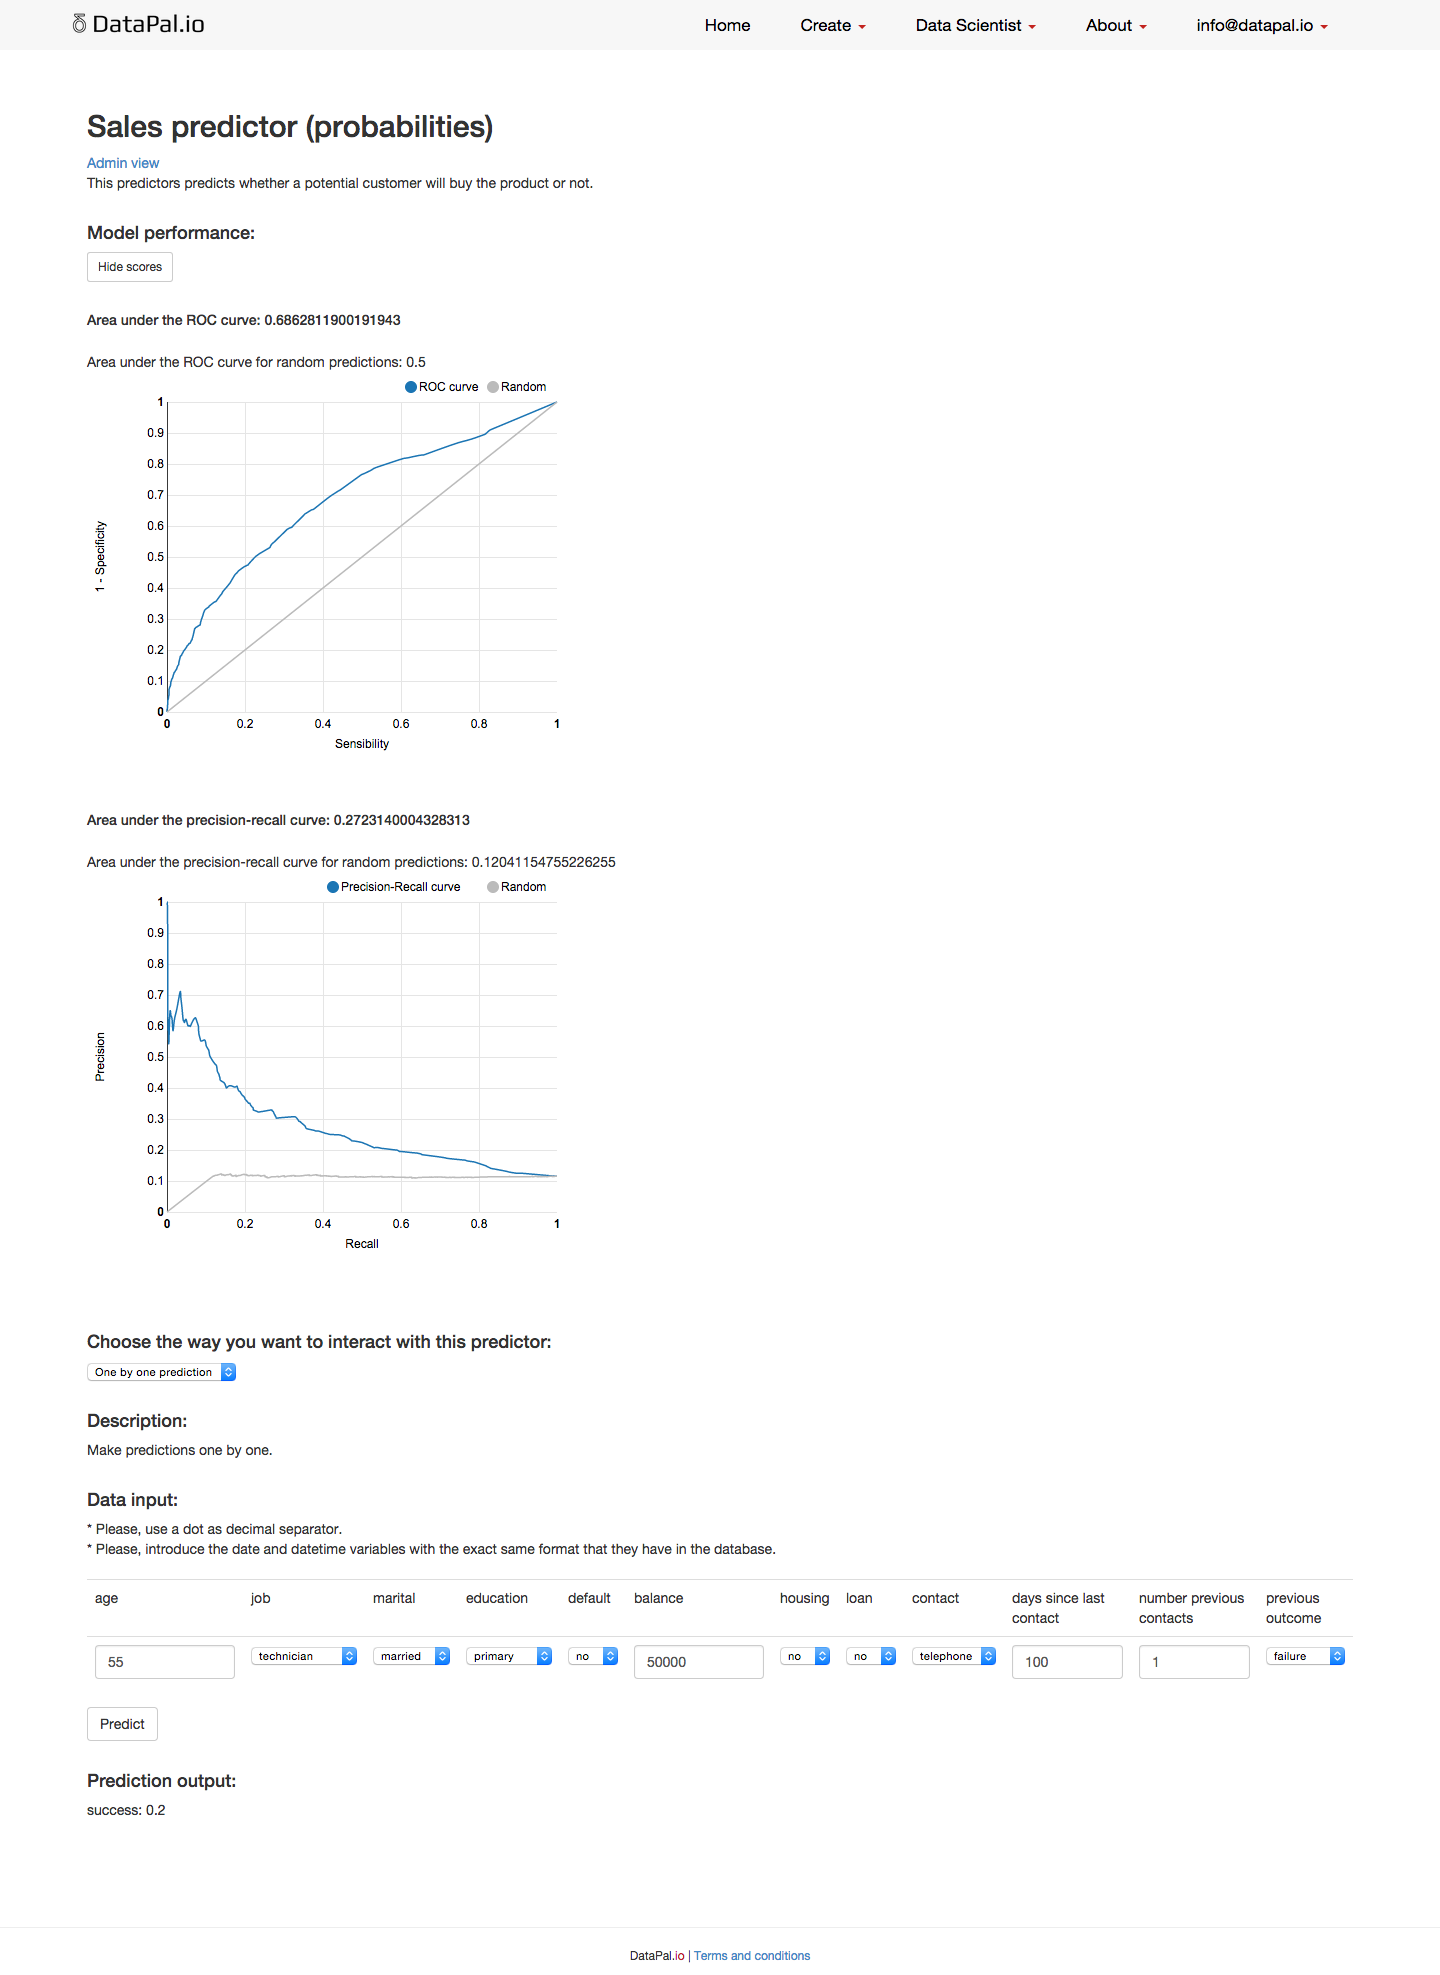

In [6]:
from IPython.display import Image
Image(filename='./bank_prob_interface.png')